# Face recognition using OpenCV

In [1]:
import os
import cv2
import imutils
import cv2
import argparse
import pandas as pd
import numpy as np
from random import randint
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import sys
sys.path.append('../') 
from utils import show_side_by_side, load_image_as_array, show_image

### Load the OpenCV face detector

In [2]:
protoPath = '../opencv_face_recognition/face_detector/deploy.prototxt'
modelPath = '../opencv_face_recognition/face_detector/res10_300x300_ssd_iter_140000_fp16.caffemodel'
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

In [3]:
embedding_model = '../opencv_face_recognition/openface/nn4.small2.v1.t7'
embedder = cv2.dnn.readNetFromTorch(embedding_model)

In [4]:
num_images_per_person = 20
names = ['Tony_Blair', 'Serena_Williams']

confidence = 0.5
mean_subtract_values = (104, 177, 123)
embeddings_file = '../classifier_data/face_embeddings.p'
recogniser_file = '../classifier_data/recogniser.p'
labels_file = '../classifier_data/labels.p'

### Create a sample dataset

We'll get 10 images for 2 known people, and 10 from a random selection of other people

In [5]:
lfw_dir = '../lfw'

X, y = [], []
for name in names:
    X_name, y_name = [], []
    images = os.listdir(os.path.join(lfw_dir, name))
    for i in range(num_images_per_person):
        filename = os.path.join(lfw_dir, name, images[i]) 
        X.append(filename)
        y.append(name)
                    
df_names = pd.read_csv(os.path.join(lfw_dir, 'lfw-names.txt'), delim_whitespace=True, names=['name', 'count'])
df_names = df_names[~df_names['name'].isin(names)]
df_names = df_names.sort_values(by=['count'], ascending=False).reset_index()

for i in range(num_images_per_person):
    unknown_idx = randint(0, len(df_names) - 1 )
    name = df_names.iloc[unknown_idx]['name']
    df_names = df_names[df_names['name'] != name]
    images = os.listdir(os.path.join(lfw_dir, name))
    image_idx = randint(0, len(images) - 1)
    X.append(os.path.join(lfw_dir, name, images[image_idx]))
    y.append('Unknown')   

* Loop through the images and create a blob for each one.

Note that we normalise the image by subtracting the mean values from red, green and blue. The helps with variations in illumination between images and helps the CNN work (see https://github.com/opencv/opencv/tree/master/samples/dnn)

In [6]:
def get_face_embeddings_from_image(image):
    vec = []
    #image = cv2.imread(image_path)
    imageBlob = cv2.dnn.blobFromImage(
        cv2.resize(image, (300, 300)), 1.0, (300, 300),
        mean_subtract_values, swapRB=False, crop=False)
    (h, w) = image.shape[:2]

    # apply OpenCV's deep learning-based face detector to localize faces in the input image
    detector.setInput(imageBlob)
    predictions = detector.forward()
    # We need one face to continue
    if len(predictions) > 0:
        # Find the bounding box with the largest probability
        i = np.argmax(predictions[0, 0, :, 2])
        conf = predictions[0, 0, i, 2]
 
        # Find the bounding box with the highest confidence
        if conf > confidence:
            # Find the bounding box and extract the face
            box = predictions[0, 0, i, 3:7] * np.array([w, h, w, h])
            start_x, start_y, end_x, end_y = box.astype("int")
            face = image[start_y:end_y, start_x:end_x]
 
            # Ensure the face width and height are sufficiently large
            if face.shape[0] >= 20 and face.shape[1] > 20:
                # construct a blob for the face ROI, then pass the blob through our face embedding model 
                # to obtain the 128-d vector
                faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,
                    (96, 96), (0, 0, 0), swapRB=True, crop=False)
                embedder.setInput(faceBlob)
                vec = embedder.forward()
    return (start_x, start_y, end_x, end_y), vec

In [7]:
embeddings = {'names': [], 'embeddings': []}
for i, (image_path, name) in enumerate(zip(X, y)):
    image = load_image_as_array(image_path)
    print('Processing image {}'.format(image_path))
    _, face_embedding_vector = get_face_embeddings_from_image(image)
    if face_embedding_vector != []:
        embeddings['names'].append(name)
        embeddings['embeddings'].append(face_embedding_vector[0])

Processing image ../lfw\Tony_Blair\Tony_Blair_0001.jpg


C:\Users\mastreff\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  


Processing image ../lfw\Tony_Blair\Tony_Blair_0002.jpg
Processing image ../lfw\Tony_Blair\Tony_Blair_0003.jpg
Processing image ../lfw\Tony_Blair\Tony_Blair_0004.jpg
Processing image ../lfw\Tony_Blair\Tony_Blair_0005.jpg
Processing image ../lfw\Tony_Blair\Tony_Blair_0006.jpg
Processing image ../lfw\Tony_Blair\Tony_Blair_0007.jpg
Processing image ../lfw\Tony_Blair\Tony_Blair_0008.jpg
Processing image ../lfw\Tony_Blair\Tony_Blair_0009.jpg
Processing image ../lfw\Tony_Blair\Tony_Blair_0010.jpg
Processing image ../lfw\Tony_Blair\Tony_Blair_0011.jpg
Processing image ../lfw\Tony_Blair\Tony_Blair_0012.jpg
Processing image ../lfw\Tony_Blair\Tony_Blair_0013.jpg
Processing image ../lfw\Tony_Blair\Tony_Blair_0014.jpg
Processing image ../lfw\Tony_Blair\Tony_Blair_0015.jpg
Processing image ../lfw\Tony_Blair\Tony_Blair_0016.jpg
Processing image ../lfw\Tony_Blair\Tony_Blair_0017.jpg
Processing image ../lfw\Tony_Blair\Tony_Blair_0018.jpg
Processing image ../lfw\Tony_Blair\Tony_Blair_0019.jpg
Processing

* Check how many embeddings we've created

Note that some images in the LFW dataset fail embeddings due to low confidence from OpenCV or the face size is too small.

In [8]:
print('Created {} embeddings.'.format(len(embeddings['names'])))

Created 60 embeddings.


* Save our embeddings using Pickle

In [9]:
pickle.dump(embeddings, open(embeddings_file, 'wb' ))

### Let's train a model

In [10]:
embeddings = pickle.load(open(embeddings_file, 'rb' ))

In [11]:
le = LabelEncoder()
labels = le.fit_transform(embeddings['names'])

In [12]:
recogniser = SVC(C=1.0, kernel="linear", probability=True)
recogniser.fit(embeddings['embeddings'], labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

* And let's save our model

In [13]:
pickle.dump(recogniser, open(recogniser_file, 'wb'))
pickle.dump(le, open(labels_file, 'wb'))

### Now let's recognise faces

In [14]:
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
embedder = cv2.dnn.readNetFromTorch(embedding_model)
recogniser = pickle.load(open(recogniser_file, 'rb'))
le = pickle.load(open(labels_file, 'rb'))

* Pick a random image from our dataset

Note that we might pick one we trained with, but both of these people have a lot of images to choose from

Trying to recognise faces in ../lfw\Serena_Williams\Serena_Williams_0026.jpg


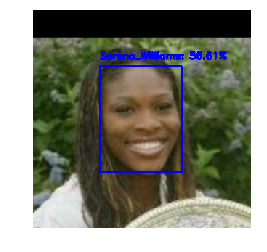

Trying to recognise faces in ../lfw\Tony_Blair\Tony_Blair_0006.jpg


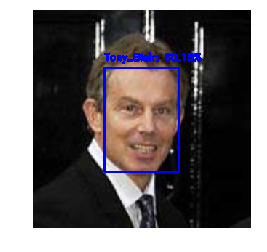

Trying to recognise faces in ../lfw\Tony_Blair\Tony_Blair_0033.jpg


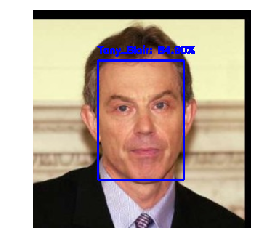

Trying to recognise faces in ../lfw\Serena_Williams\Serena_Williams_0001.jpg


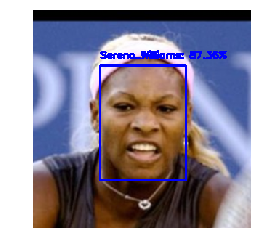

Trying to recognise faces in ../lfw\Tony_Blair\Tony_Blair_0065.jpg


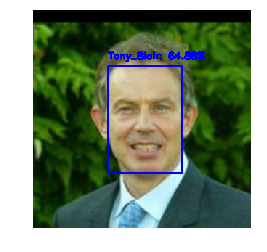

Trying to recognise faces in ../lfw\Serena_Williams\Serena_Williams_0045.jpg


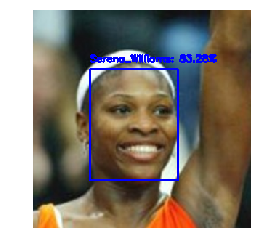

Trying to recognise faces in ../lfw\Serena_Williams\Serena_Williams_0007.jpg


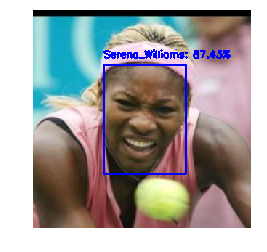

Trying to recognise faces in ../lfw\Serena_Williams\Serena_Williams_0014.jpg


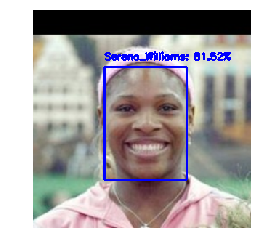

Trying to recognise faces in ../lfw\Serena_Williams\Serena_Williams_0035.jpg


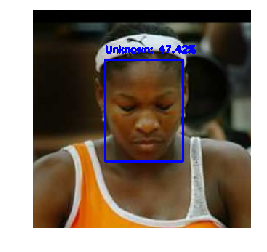

Trying to recognise faces in ../lfw\Tony_Blair\Tony_Blair_0083.jpg


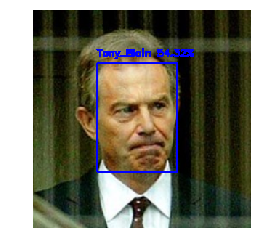

Trying to recognise faces in ../lfw\Serena_Williams\Serena_Williams_0002.jpg


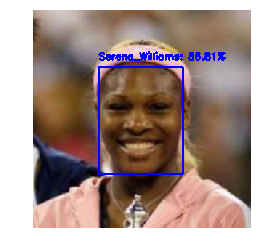

Trying to recognise faces in ../lfw\Tony_Blair\Tony_Blair_0121.jpg


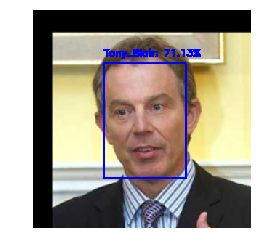

Trying to recognise faces in ../lfw\Serena_Williams\Serena_Williams_0028.jpg


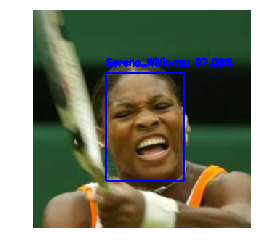

Trying to recognise faces in ../lfw\Tony_Blair\Tony_Blair_0054.jpg


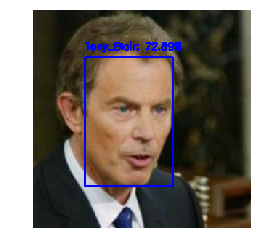

Trying to recognise faces in ../lfw\Serena_Williams\Serena_Williams_0035.jpg


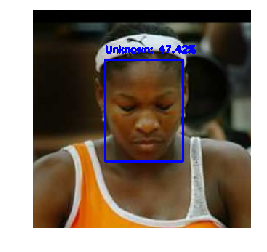

Trying to recognise faces in ../lfw\Tony_Blair\Tony_Blair_0077.jpg


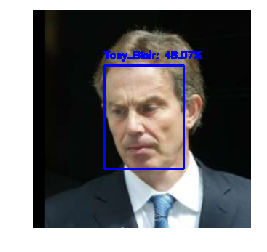

Trying to recognise faces in ../lfw\Tony_Blair\Tony_Blair_0021.jpg


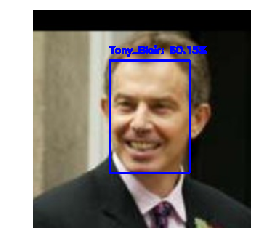

Trying to recognise faces in ../lfw\Tony_Blair\Tony_Blair_0079.jpg


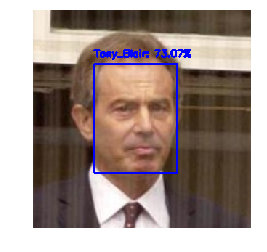

Trying to recognise faces in ../lfw\Serena_Williams\Serena_Williams_0041.jpg


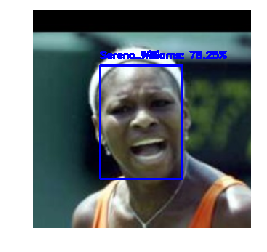

Trying to recognise faces in ../lfw\Serena_Williams\Serena_Williams_0033.jpg


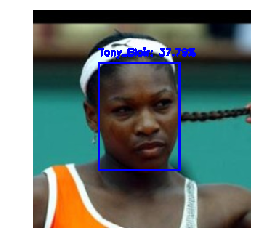

In [18]:
for i in range(num_images_per_person):
    name = names[randint(0, len(names) - 1)]
    images = os.listdir(os.path.join(lfw_dir, name))
    filename = os.path.join(lfw_dir, name, images[randint(0, len(images) - 1)])
    print('Trying to recognise faces in {}'.format(filename))
    image = load_image_as_array(filename)

    # imageBlob = cv2.dnn.blobFromImage(
    #     cv2.resize(image, (300, 300)), 1.0, (300, 300),
    #     mean_subtract_values, swapRB=False, crop=False)

    # detector.setInput(imageBlob)
    # detections = detector.forward()

    box, vec = get_face_embeddings_from_image(image)

    predictions = recogniser.predict_proba(vec)[0]
    j = np.argmax(predictions)
    proba = predictions[j]
    name = le.classes_[j]

    start_x, start_y, end_x, end_y = box
    text = "{}: {:.2f}%".format(name, proba * 100)
    y = start_y - 10 if start_y - 10 > 10 else start_y + 10
    cv2.rectangle(image, (start_x, start_y), (end_x, end_y),
        (0, 0, 255), 2)
    cv2.putText(image, text, (start_x, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

    show_image(image)